Deputado Histogramado
============

[expressao.xyz/deputado/](http://expressao.xyz/deputado/)

Como processar as sessões do parlamento Português

Índice
-----

1. [Reunir o dataset](Deputado-Histogramado-1.ipynb)
2. [Contando as palavras mais comuns](Deputado-Histogramado-2.ipynb)
3. [Fazendo histogramas](Deputado-Histogramado-3.ipynb)
4. [Representações geograficas](Deputado-Histogramado-4.ipynb)
5. [Simplificar o dataset e exportar para o expressa.xyz/deputado/](Deputado-Histogramado-5.ipynb)

O que se passou nas mais de 4000 sessões de discussão do parlamento Português que ocorreram desde 1976? 
Neste notebook vamos tentar visualizar o que se passou da maneira mais simples - contando palavras, e fazendo gráficos.

Para obter os textos de todas as sessões usaremos o [demo.cratica.org](demo.cratica.org), onde podemos aceder facilmente a todas as sessões do parlamento de 1976 a 2015. Depois com um pouco de python, pandas e matplotlib vamos analisar o que se passou.

Para executar estes notebook será necessário descarregar e abrir com o Jupiter Notebooks (a distribuição Anaconda faz com que instalar todas as ferramentas necessárias seja fácil - https://www.continuum.io/downloads)


## Parte 1 - Reunir o dataset


Comecemos por carregar as sessões para um dataframe de pandas, para as podermos analisar mais facilmente. O demo.cratica.org esta organizado /sessoes/ano/mes/dia/. A quantidade todal de dadosé da ordem de 900 MB portanto cuidado com o trafego. E atenção que a transferencia de dados pode demorar bastante.

Para cada data entre 1976 e 2015, vamos tentar transferir a página do democratica. Para as que existem, vamos extrair os dados na tag 'entry-content', remover as translineações e as tags, e passar para lowercase (pois o nosso propósito é contar palavras e ocorrências). Guardemos estes dados em duas listas (lista_datas, lista_sessoes), que depois vao ser transformadas nas duas colunas de um DataFrame de Pandas.

In [9]:
from urllib import request   
import zlib
import pandas
from bs4 import BeautifulSoup #para processar o HTML
import re #para processar o html


lista_datas = []
lista_sessoes = []
bytesTransferidos = 0
i = 0
for ano in range(1976,2016):
    for mes in range(1,13):
        print("Processando %04d/%02d - bytes transferidos = %d..."%(ano,mes,bytesTransferidos))
        for dia in range(1,32): #para cada dia possível, tenta transferiro ficheiro
            url = "http://demo.cratica.org/sessoes/%04d/%02d/%02d/"%(ano,mes,dia)
            #url = "http://localhost:7888/radio-parlamento/backup170221/sessoes/%04d/%02d/%02d/"%(ano,mes,dia)
            #transfere a pagina usando urllib 
            r = request.Request(url)
            try: 
                with request.urlopen(r) as f:   #transfere o site
                    dados = f.read()

                    bytesTransferidos = bytesTransferidos + len(dados)  #contabiliza quanto trafego estamos a usar
                    # os dados em HTML têm mais informaçao do que queremos. vamos seleccionar apenas o elemento 'entre-content', que tem o texto do parlamento
                    dados = ''.join([str(x).strip() for x in BeautifulSoup(dados,'lxml').find('div', class_="entry-content").find_all()])
                    # vamos retirar as tags de paragrafos e corrigir as translineações
                    dados = dados.replace('-</p><p>','').replace('</p>',' ').replace('<p>',' ')
                    # vamos retirar tags que faltem, pois nao interessam para a nossa análise (usando uma expressao regular, e assumindo que o codigo é html válido)
                    dados = re.sub('<[^>]*>', '', dados)
                    # texto para lowercase, para as procuras de palavras funcionarem independentemente da capitalização
                    dados = dados.lower()
                   
                    if(len(dados) > 100): #se o texto nao for inexistente ou demasiado pequeno, adiciona á lista de sessões (há páginas que existem, mas não têm texto)
                        lista_datas.append("%04d-%02d-%02d"%(ano,mes,dia))
                        lista_sessoes.append(dados)

            except request.URLError:  #ficheiro nao existe, passa ao próximo
                pass

print('%d bytes transferidos, %d sessoes transferidas, entre %s e %s'%(bytesTransferidos,len(lista_sessoes), min(lista_datas).format(), max(lista_datas).format()))
    
dados = {'data': pandas.DatetimeIndex(lista_datas), 'sessao': lista_sessoes }
sessoes = pandas.DataFrame(dados, columns={'data','sessao'})


Processando 1976/01 - bytes transferidos = 0...
Processando 1976/02 - bytes transferidos = 0...
Processando 1976/03 - bytes transferidos = 0...
Processando 1976/04 - bytes transferidos = 0...
Processando 1976/05 - bytes transferidos = 0...
Processando 1976/06 - bytes transferidos = 0...
Processando 1976/07 - bytes transferidos = 425102...
Processando 1976/08 - bytes transferidos = 2171521...
Processando 1976/09 - bytes transferidos = 3939266...
Processando 1976/10 - bytes transferidos = 3939266...
Processando 1976/11 - bytes transferidos = 6242384...
Processando 1976/12 - bytes transferidos = 8752193...
Processando 1977/01 - bytes transferidos = 12179703...
Processando 1977/02 - bytes transferidos = 13271241...
Processando 1977/03 - bytes transferidos = 15876096...
Processando 1977/04 - bytes transferidos = 18498836...
Processando 1977/05 - bytes transferidos = 20342062...
Processando 1977/06 - bytes transferidos = 22768112...
Processando 1977/07 - bytes transferidos = 25101746...
Proc

Agora que temos os dados num dataframe podemos imediatamente tirar partido deles. Por exemplo representar o tamanho das sessoes em bytes ao longo do tempo é straightforward:

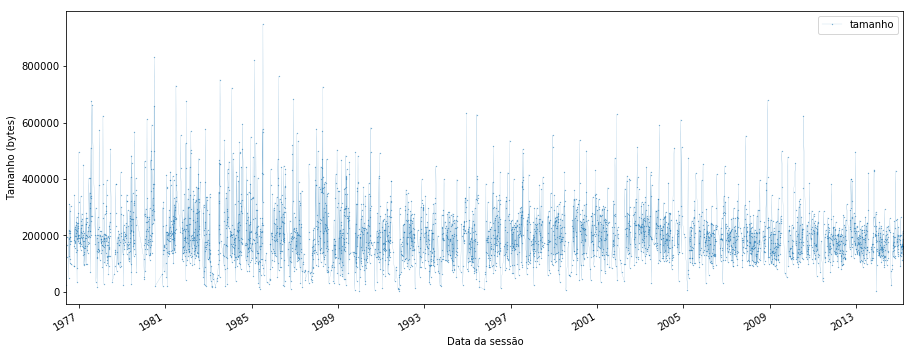

In [10]:
%matplotlib inline
import pylab
import matplotlib

#aplica a funcao len/length a cada elemento da series de dados, 
# criando uma columna com o numero de bytes de cada sessao
sessoes['tamanho'] = sessoes['sessao'].map(len)

#representa num grafico
ax = sessoes.plot(x='data',y='tamanho',figsize=(15,6),linewidth=0.1,marker='.',markersize=0.5)
ax.set_xlabel('Data da sessão')
ax.set_ylabel('Tamanho (bytes)')

A sessão média é mais ou menos constante da ordem dos 200 mil bytes, excepto algumas sessões que periodicamente têm mais conteúdo (até >4x mais caracteres). 

A próxima coisa a fazer será guardar os dados, para não os termos que transferir novamente, e podermos usar nas próximas análises:

In [11]:
sessoes.to_csv('sessoes_democratica_org.csv')

Verificando o nome e tamanho do ficheiro:

In [1]:
import os
print(str(os.path.getsize('sessoes_democratica_org.csv')) + ' bytes')
print(os.getcwd()+'/sessoes_democratica_org.csv')

827604554 bytes
/Users/fsilva/expressao.xyz/deputado-histogramado/notebooks/sessoes_democratica_org.csv


Código para carregar os dados: 

(este notebook pode ser começado por esta linha, se o ficheiro já existir)

In [1]:
%matplotlib inline
import pylab
import matplotlib
import pandas
import numpy


dateparse = lambda x: pandas.datetime.strptime(x, '%Y-%m-%d')
sessoes = pandas.read_csv('sessoes_democratica_org.csv',index_col=0,parse_dates=['data'], date_parser=dateparse)

Vamos só verificar se os dados ainda estão perceptíveis. Um ponto importante é se os acentos e cedilhas estão bem interpretados, pois gravar e abrir ficheiros pode confundir o python.

In [14]:
sessoes

,sessao,data,tamanho
0,"número 1 sexta-feira, 4 de junho de 1976 di...",1976-06-03,24059
1,"número 2 sábado, 5 de junho de 1976 diário ...",1976-06-04,167448
2,"número 3 sexta-feira, 9 de julho de 1976 di...",1976-06-08,122209
3,"número 4 sábado, 10 julho de 1976 diário da ...",1976-06-09,193163
4,"número 5 quarta-feira, 14 de julho de 1976 ...",1976-07-13,192447
5,"número 6 quinta-feira, 15 de julho de 1976 d...",1976-07-14,50407
6,"número 7 sexta-feira, 16 de julho de 1976 di...",1976-07-15,209123
7,"número 8 sábado, 17 de julho de 1976 diário ...",1976-07-16,214826
8,"número 9 quarta-feira, 21 de julho de 1976 d...",1976-07-20,311927
9,número 10 quinta-feira 22 de julho de 1976 d...,1976-07-21,219803


Tudo OK. Óptimo. Vendo o inicio e fim da tabela reparamos imediatamente que o formato das sessões mudou de 1976 para 2015, de ter 'Número X' primeiro para a data por extenso primeiro. Passemos á frente.